In [ ]:
'''Modules import'''

import os

#analyses audio. extracts the data
import time
import pickle
import librosa
import numpy as np
import pandas as pd
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt

#plays audio files
from IPython.display import Audio

#sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.utils.multiclass import unique_labels

# Keras
import keras
from keras.layers import Dense
from keras import regularizers
from keras.utils import np_utils
from tensorflow.keras import optimizers
from keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization

%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
def aug_graph(data):
    plt.figure(figsize=(15, 5))
    librosa.display.waveplot(data, sr=sample_rate)
    

In [ ]:
#White Noise
def noise(data):

    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data_noise = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])

    return data_noise

In [ ]:
#Random Shifting
def shift(data):
  s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
  data_shift = np.roll(data, s_range)

  return data_shift

In [ ]:
#Pitch Tuning
def pitch(data):
  
  bins_per_octave = 12
  pitch_pm = 2
  pitch_change =  pitch_pm * 2*(np.random.uniform())   
  data_pitch = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)

  return data_pitch

In [ ]:
#speed and Pitch Tuning
def speedNpitch(data):
  
  length_change = np.random.uniform(low=0.8, high = 1)
  speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
  tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
  minlen = min(data.shape[0], tmp.shape[0])
  data_speedNpitch = data * 0
  data_speedNpitch[0:minlen] = tmp[0:minlen]

  return data_speedNpitch

In [ ]:
'''Feature Extraction'''

#Mel Spectogram
def mel_ft(data, hop_length=512, n_fft=2048):

  mel = librosa.feature.melspectrogram(data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=12)
  mel_power = librosa.power_to_db(mel)
  
  return mel, mel_power

In [ ]:
def rms_graph(rms, data, hop_length=512):

  frames = range(len(rms))
  t = librosa.frames_to_time(frames, hop_length=hop_length)

  librosa.display.waveplot(data, alpha=0.5)
  plt.plot(t, rms, color="r")


In [ ]:
#Zero-crossing rate

def zcr_ft(data, hop_length=512):

  zcr = librosa.feature.zero_crossing_rate(data, hop_length=hop_length)[0]

  return zcr

In [ ]:
#chroma
def chroma_ft(data):

      stft = np.abs(librosa.stft(data))
      chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
      
      return chroma


In [ ]:
#MFCCs

def mfccs_ft(data, sample_rate, hop_length=512):

  mfccs = librosa.feature.mfcc(data, sr= sample_rate, n_mfcc=13, hop_length=hop_length, n_fft=2048)

  return mfccs


In [ ]:
audio_df = pd.read_csv("./Data_path.csv")
print("AUDIO_DF length: ", len(audio_df))
audio_df.head()

AUDIO_DF length:  11257


,label,path
0,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_date_disgu...
1,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_rag_disgus...
2,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_raise_disg...
3,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_ditch_disg...
4,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_door_disgu...


In [ ]:
#Augmented Data

f_mfccs_pd_noise = pd.DataFrame(columns=['f_mfccs'])
f_mel_pd_noise = pd.DataFrame(columns=['f_mel'])
f_chroma_pd_noise = pd.DataFrame(columns=['f_chroma'])

f_mfccs_pd_shift = pd.DataFrame(columns=['f_mfccs'])
f_mel_pd_shift = pd.DataFrame(columns=['f_mel'])
f_chroma_pd_shift = pd.DataFrame(columns=['f_chroma'])

f_mfccs_pd_pitch = pd.DataFrame(columns=['f_mfccs'])
f_mel_pd_pitch = pd.DataFrame(columns=['f_mel'])
f_chroma_pd_pitch = pd.DataFrame(columns=['f_chroma'])

f_mfccs_pd_speedNpitch = pd.DataFrame(columns=['f_mfccs'])
f_mel_pd_speedNpitch = pd.DataFrame(columns=['f_mel'])
f_chroma_pd_speedNpitch= pd.DataFrame(columns=['f_chroma'])


In [14]:
print("\nAugmented Data")
print("------------------------------------------")
print("Processing...")

tic = time.perf_counter()
counter = 0

for i, path in enumerate(audio_df.path):

  tac = time.perf_counter()
  audio_data, sample_rate = librosa.load(path)
      
  #NOISE
  audio_data_noise = noise(audio_data)

  mfccs_noise = np.mean(librosa.feature.mfcc(audio_data_noise, sr=sample_rate, n_mfcc=13).T, axis=0)
  mel_noise, mel_power_noise = mel_ft(audio_data)

  chroma_noise = np.mean(chroma_ft(audio_data_noise).T, axis=0)
    
  f_mel_pd_noise.loc[counter] = [np.mean(mel_noise.T, axis=0)]
  f_chroma_pd_noise.loc[f"chroma {counter}"] = [chroma_noise]
  f_mfccs_pd_noise.loc[f"mfccs {counter}"] = [mfccs_noise]

  #SHIFT
  audio_data_shift = shift(audio_data)

  mfccs_shift = np.mean(librosa.feature.mfcc(audio_data_shift, sr=sample_rate, n_mfcc=13), axis=0)
  mel_shift, mel_power_shift = mel_ft(audio_data)
  chroma_shift = np.mean(chroma_ft(audio_data_shift), axis=0)

  f_mel_pd_shift.loc[counter] = [np.mean(mel_shift.T, axis=0)]
  f_chroma_pd_shift.loc[f"chroma {counter}"] = [chroma_shift]
  f_mfccs_pd_shift.loc[f"mfccs {counter}"] = [mfccs_shift]

  #Pitch
  audio_data_pitch = pitch(audio_data)

  mfccs_pitch = np.mean(librosa.feature.mfcc(audio_data_pitch, sr=sample_rate, n_mfcc=13), axis=0)
  mel_pitch, mel_power_pitch = mel_ft(audio_data)
  chroma_pitch = np.mean(chroma_ft(audio_data_pitch), axis=0)

  f_mel_pd_pitch.loc[counter] = [np.mean(mel_pitch.T, axis=0)]
  f_chroma_pd_pitch.loc[f"chroma {counter}"] = [chroma_pitch]
  f_mfccs_pd_pitch.loc[f"mfccs {counter}"] = [mfccs_pitch]

  #SpeedNpitch
  audio_data_speedNpitch= speedNpitch(audio_data)

  mfccs_speedNpitch = np.mean(librosa.feature.mfcc(audio_data_speedNpitch, sr=sample_rate, n_mfcc=13), axis=0)
  mel_speedNpitch, mel_power_speedNpitch = mel_ft(audio_data)
  chroma_speedNpitch = np.mean(chroma_ft(audio_data_speedNpitch), axis=0)

  f_mel_pd_speedNpitch.loc[counter] = [np.mean(mel_speedNpitch.T, axis=0)]
  f_chroma_pd_speedNpitch.loc[f"chroma {counter}"] = [chroma_speedNpitch]
  f_mfccs_pd_speedNpitch.loc[f"mfccs {counter}"] = [mfccs_speedNpitch]


  counter=counter+1
  toc = time.perf_counter()
  print("...............................")
  print(f"Time: {toc - tac:0.4f} seconds")
  print(f"{i} out of {len(audio_df)}")
  print("...............................")

tec = time.perf_counter()
print(f"Time: {tec - tic:0.4f} seconds")

print("Done")
print("------------------------------------------")



Augmented Data
------------------------------------------
Processing...
...............................
Time: 3.3075 seconds
0 out of 11257
...............................
...............................
Time: 0.8166 seconds
1 out of 11257
...............................
...............................
Time: 0.7893 seconds
2 out of 11257
...............................
...............................
Time: 0.7411 seconds
3 out of 11257
...............................
...............................
Time: 0.7444 seconds
4 out of 11257
...............................
...............................
Time: 0.6782 seconds
5 out of 11257
...............................
...............................
Time: 0.7862 seconds
6 out of 11257
...............................
...............................
Time: 0.7106 seconds
7 out of 11257
...............................
...............................
Time: 0.5577 seconds
8 out of 11257
...............................
...........................

/Users/sofiavalente/anaconda3/envs/my-env/lib/python3.9/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


...............................
Time: 1.1267 seconds
7453 out of 11257
...............................
...............................
Time: 0.6548 seconds
7454 out of 11257
...............................
...............................
Time: 0.8502 seconds
7455 out of 11257
...............................
...............................
Time: 0.6383 seconds
7456 out of 11257
...............................
...............................
Time: 0.8056 seconds
7457 out of 11257
...............................
...............................
Time: 0.5758 seconds
7458 out of 11257
...............................
...............................
Time: 0.7365 seconds
7459 out of 11257
...............................
...............................
Time: 0.7529 seconds
7460 out of 11257
...............................
...............................
Time: 0.6737 seconds
7461 out of 11257
...............................
...............................
Time: 0.6388 seconds
7462 out of 11257
..

In [15]:
def features(data, mfccs_df, mel_df, chroma_df):
  
  features_df = pd.concat([data,
                        pd.DataFrame(mfccs_df['f_mfccs'].values.tolist()),
                        pd.DataFrame(chroma_df['f_chroma'].values.tolist()),
                        pd.DataFrame(mel_df['f_mel'].values.tolist())],
                        axis=1)
  
  return features_df

In [16]:
features_df_noise = features(audio_df, f_mfccs_pd_noise, f_mel_pd_noise, f_chroma_pd_noise)
features_df_shift = features(audio_df, f_mfccs_pd_shift, f_mel_pd_shift, f_chroma_pd_shift)
features_df_pitch = features(audio_df, f_mfccs_pd_pitch, f_mel_pd_pitch, f_chroma_pd_pitch)
features_df_speedNpitch = features(audio_df, f_mfccs_pd_speedNpitch, f_mel_pd_speedNpitch, f_chroma_pd_speedNpitch)


In [17]:
'''Check and replace nan value with 0'''

def check_nan(features):
  features_df=features.fillna(0)

  print("------------------------------------------")
  
  print("features_df Shape: ", features_df.shape, "\n")
  features_df[:5]


  print("Nan features: ", features_df.isnull().values.any())
  print("Count Nan features: ", features_df.isnull().sum().sum())
  
  print("------------------------------------------")

  return features_df

In [18]:
features_df_noise = check_nan(features_df_noise)
features_df_shift = check_nan(features_df_shift)
features_df_pitch = check_nan(features_df_pitch)
features_df_speedNpitch = check_nan(features_df_speedNpitch)


------------------------------------------
features_df Shape:  (11257, 39) 

Nan features:  False
Count Nan features:  0
------------------------------------------
------------------------------------------
features_df Shape:  (11257, 788) 

Nan features:  False
Count Nan features:  0
------------------------------------------
------------------------------------------
features_df Shape:  (11257, 788) 

Nan features:  False
Count Nan features:  0
------------------------------------------
------------------------------------------
features_df Shape:  (11257, 788) 

Nan features:  False
Count Nan features:  0
------------------------------------------


In [19]:
def train_def(features_df):

  x_train, x_test, y_train, y_test = train_test_split(features_df.drop(['path','label'],axis=1), 
                                                      features_df.label,
                                                      test_size=0.25,
                                                      shuffle=True,
                                                      random_state=42
                                                      )

  return x_train, x_test, y_train, y_test


In [20]:
x_train_noise, x_test_noise, y_train_noise, y_test_noise = train_def(features_df_noise)
x_train_shift, x_test_shift, y_train_shift, y_test_shift = train_def(features_df_shift)
x_train_pitch, x_test_pitch, y_train_pitch, y_test_pitch = train_def(features_df_pitch)
x_train_speedNpitch, x_test_speedNpitch, y_train_speedNpitch, y_test_speedNpitch = train_def(features_df_speedNpitch)


In [21]:
'''Feature Scaling'''

def normalization(x_train, x_test): 

  scaler = StandardScaler()
  X_train = scaler.fit_transform(x_train)
  X_test = scaler.transform(x_test)


  print("x_train shape: ", x_train.shape)

  x_train=x_train.fillna(0)
  x_test=x_test.fillna(0)


  return x_train, x_test


In [22]:
x_train_noise, x_test_noise = normalization(x_train_noise, x_test_noise)
x_train_shift, x_test_shift = normalization(x_train_shift, x_test_shift)
x_train_pitch, x_test_pitch = normalization(x_train_pitch, x_test_pitch)
x_train_speedNpitch, x_test_speedNpitch = normalization(x_train_speedNpitch, x_test_speedNpitch)

x_train shape:  (8442, 37)
x_train shape:  (8442, 786)
x_train shape:  (8442, 786)
x_train shape:  (8442, 786)


# **SVM Model**

In [23]:
'''Models'''

#SVM
def svm_model(x_train,x_test, y_train, y_test):
    
  svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x_train, y_train) 
  svm_predictions = svm_model_linear.predict(x_test) 

  svm_accuracy = accuracy_score(y_true=y_test, y_pred=svm_predictions)
  svm_classification = classification_report(y_test,svm_predictions)
  
  print("------------------------------------------")

  print("Accuracy:", svm_accuracy*100 , "%")
  print("Classification: \n", svm_classification) 

  return svm_predictions
  

In [24]:
#Confusion matrix

def conf_matrix_svm(y_test, svm_predictions):
  
  plot_labels = ['angry', 'anxiety/fear', 'boredom', 'disgust', 'happiness', 'neutral', 'sadness']

  svm_conf_matrix = pd.DataFrame(confusion_matrix(y_test, svm_predictions))

  fig, ax = plt.subplots()
  im = ax.imshow(svm_conf_matrix, interpolation='nearest')
  ax.figure.colorbar(im, ax=ax)
  plt.title("Confusion Matrix")

  tick_marks = np.arange(len(plot_labels))
  plt.xticks(tick_marks, plot_labels, rotation=45)
  plt.yticks(tick_marks, plot_labels)


In [25]:
svm_predictions_noise = svm_model(x_train_noise,x_test_noise, y_train_noise, y_test_noise)
svm_predictions_shift = svm_model(x_train_shift,x_test_shift, y_train_shift, y_test_shift)
svm_predictions_pitch = svm_model(x_train_pitch,x_test_pitch, y_train_pitch, y_test_pitch)
svm_predictions_speedNpitch = svm_model(x_train_speedNpitch,x_test_speedNpitch, y_train_speedNpitch, y_test_speedNpitch)

------------------------------------------
Accuracy: 53.14387211367673 %
Classification: 
               precision    recall  f1-score   support

       angry       0.61      0.74      0.67       484
anxiety/fear       0.46      0.37      0.41       443
     boredom       0.69      0.79      0.74       137
     disgust       0.43      0.42      0.42       439
    hapiness       0.95      0.81      0.87        94
   happiness       0.36      0.27      0.31       360
     neutral       0.51      0.47      0.49       391
     sadness       0.56      0.69      0.62       467

    accuracy                           0.53      2815
   macro avg       0.57      0.57      0.57      2815
weighted avg       0.52      0.53      0.52      2815

------------------------------------------
Accuracy: 41.27886323268206 %
Classification: 
               precision    recall  f1-score   support

       angry       0.63      0.61      0.62       484
anxiety/fear       0.32      0.38      0.34       443
    

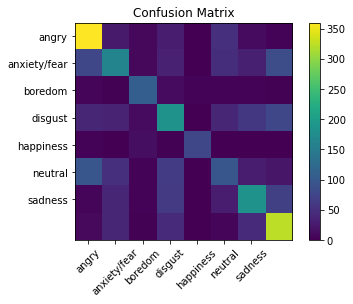

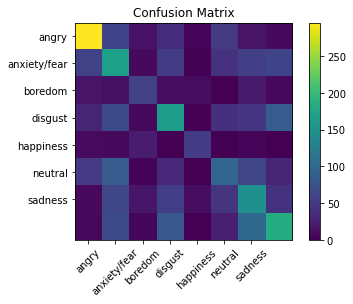

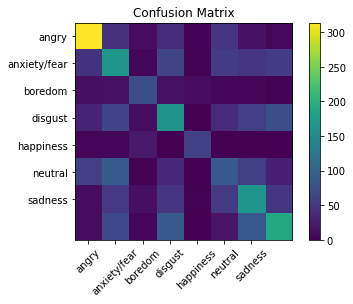

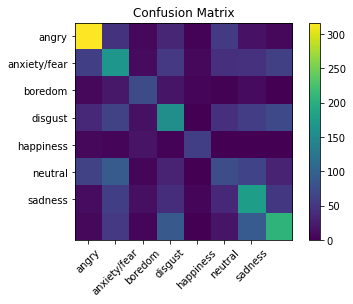

In [26]:
conf_matrix_svm(y_test_noise, svm_predictions_noise)
conf_matrix_svm(y_test_shift, svm_predictions_shift)
conf_matrix_svm(y_test_pitch, svm_predictions_pitch)
conf_matrix_svm(y_test_speedNpitch, svm_predictions_speedNpitch)


# **CNN Model**

In [27]:
def list_to_np(x_train, y_train, x_test, y_test):
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_test = np.array(x_test)
  y_test = np.array(y_test)

  return x_train, y_train, x_test, y_test

In [28]:
x_train_noise, y_train_noise, x_test_noise, y_test_noise = list_to_np(x_train_noise, y_train_noise, x_test_noise, y_test_noise)
x_train_shift, y_train_shift, x_test_shift, y_test_shift = list_to_np(x_train_shift, y_train_shift, x_test_shift, y_test_shift)
x_train_pitch, y_train_pitch, x_test_pitch, y_test_pitch = list_to_np(x_train_pitch, y_train_pitch, x_test_pitch, y_test_pitch)
x_train_speedNpitch, y_train_speedNpitch, x_test_speedNpitch, y_test_speedNpitch = list_to_np(x_train_speedNpitch, y_train_speedNpitch, x_test_speedNpitch, y_test_speedNpitch)


In [29]:
'''Label Encoder'''

def label_encoder(y_train, y_test):
  
  lb = LabelEncoder()
  y_train = np_utils.to_categorical(lb.fit_transform(y_train))
  y_test = np_utils.to_categorical(lb.fit_transform(y_test))

  # Pickel the lb object for future use 
  filename = 'Emotion'
  outfile = open(filename,'wb')
  pickle.dump(lb,outfile)
  outfile.close()

  return y_train, y_test, lb

In [30]:
y_train_noise, y_test_noise, lb = label_encoder(y_train_noise, y_test_noise)
y_train_shift, y_test_shift, lb = label_encoder(y_train_shift, y_test_shift)
y_train_pitch, y_test_pitch,lb = label_encoder(y_train_pitch, y_test_pitch)
y_train_speedNpitch, y_test_speedNpitch,lb = label_encoder(y_train_speedNpitch, y_test_speedNpitch)


In [31]:
def expand_dims(x_train, x_test):
  
  x_train = np.expand_dims(x_train, axis=2)
  x_test = np.expand_dims(x_test, axis=2)

  return x_train, x_test

In [32]:
x_train_noise, x_test_noise = expand_dims(x_train_noise, x_test_noise)
x_train_shift, x_test_shift = expand_dims(x_train_shift, x_test_shift)
x_train_pitch, x_test_pitch = expand_dims(x_train_pitch, x_test_pitch)
x_train_speedNpitch, x_test_speedNpitch = expand_dims(x_train_speedNpitch, x_test_speedNpitch)


In [41]:
'''Model'''

#CNN
def cnn_model(x_train, y_train, x_test, y_test):
  
  model = Sequential()
  model.add(Conv1D(256, 8, padding='same',input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
  model.add(Activation('relu'))

  model.add(Conv1D(256, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))

  model.add(Conv1D(128, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv1D(128, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(3)))

  model.add(Conv1D(64, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Flatten())
  model.add(Dense(8)) # Target class number
  model.add(Activation('softmax'))

  opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model_history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))
  
  model.summary()

  return model_history, model

In [42]:
model_history_noise, cnn_model_noise = cnn_model(x_train_noise, y_train_noise, x_test_noise, y_test_noise)

Epoch 1/100
132/132 [==============================] - 25s 143ms/step - loss: 2.1899 - accuracy: 0.1984 - val_loss: 1.9846 - val_accuracy: 0.2757
Epoch 2/100
132/132 [==============================] - 18s 137ms/step - loss: 2.0219 - accuracy: 0.2448 - val_loss: 1.9187 - val_accuracy: 0.2849
Epoch 3/100
132/132 [==============================] - 18s 137ms/step - loss: 1.9467 - accuracy: 0.2640 - val_loss: 1.8522 - val_accuracy: 0.3016
Epoch 4/100
132/132 [==============================] - 18s 136ms/step - loss: 1.8687 - accuracy: 0.2825 - val_loss: 1.8008 - val_accuracy: 0.3123
Epoch 5/100
132/132 [==============================] - 17s 132ms/step - loss: 1.8190 - accuracy: 0.2877 - val_loss: 1.7860 - val_accuracy: 0.2980
Epoch 6/100
132/132 [==============================] - 17s 132ms/step - loss: 1.7723 - accuracy: 0.3056 - val_loss: 1.7626 - val_accuracy: 0.3069
Epoch 7/100
132/132 [==============================] - 17s 129ms/step - loss: 1.7295 - accuracy: 0.3195 - val_loss: 1.7442 -

In [43]:
model_history_shift, cnn_model_shift = cnn_model(x_train_shift, y_train_shift, x_test_shift, y_test_shift)

Epoch 1/100
132/132 [==============================] - 253s 2s/step - loss: 1.9311 - accuracy: 0.2433 - val_loss: 2.0172 - val_accuracy: 0.1439
Epoch 2/100
132/132 [==============================] - 245s 2s/step - loss: 1.7616 - accuracy: 0.3008 - val_loss: 1.8871 - val_accuracy: 0.2199
Epoch 3/100
132/132 [==============================] - 244s 2s/step - loss: 1.6820 - accuracy: 0.3242 - val_loss: 1.7607 - val_accuracy: 0.2927
Epoch 4/100
132/132 [==============================] - 249s 2s/step - loss: 1.6350 - accuracy: 0.3433 - val_loss: 1.6826 - val_accuracy: 0.3513
Epoch 5/100
132/132 [==============================] - 249s 2s/step - loss: 1.6006 - accuracy: 0.3535 - val_loss: 1.6520 - val_accuracy: 0.3464
Epoch 6/100
132/132 [==============================] - 249s 2s/step - loss: 1.5642 - accuracy: 0.3749 - val_loss: 1.6238 - val_accuracy: 0.3613
Epoch 7/100
132/132 [==============================] - 249s 2s/step - loss: 1.5361 - accuracy: 0.3914 - val_loss: 1.6080 - val_accuracy:

In [44]:

model_history_pitch, cnn_model_pitch = cnn_model(x_train_pitch, y_train_pitch, x_test_pitch, y_test_pitch)

Epoch 1/100
132/132 [==============================] - 265s 2s/step - loss: 1.9182 - accuracy: 0.2434 - val_loss: 2.0167 - val_accuracy: 0.1787
Epoch 2/100
132/132 [==============================] - 262s 2s/step - loss: 1.7398 - accuracy: 0.3074 - val_loss: 1.8957 - val_accuracy: 0.2472
Epoch 3/100
132/132 [==============================] - 260s 2s/step - loss: 1.6727 - accuracy: 0.3321 - val_loss: 1.7535 - val_accuracy: 0.3034
Epoch 4/100
132/132 [==============================] - 261s 2s/step - loss: 1.6199 - accuracy: 0.3550 - val_loss: 1.6828 - val_accuracy: 0.3307
Epoch 5/100
132/132 [==============================] - 264s 2s/step - loss: 1.5783 - accuracy: 0.3746 - val_loss: 1.6406 - val_accuracy: 0.3563
Epoch 6/100
132/132 [==============================] - 262s 2s/step - loss: 1.5487 - accuracy: 0.3897 - val_loss: 1.6181 - val_accuracy: 0.3560
Epoch 7/100
132/132 [==============================] - 259s 2s/step - loss: 1.5119 - accuracy: 0.4112 - val_loss: 1.5909 - val_accuracy:

In [45]:
model_history_speedNpitch, cnn_model_speedNpitch = cnn_model(x_train_speedNpitch, y_train_speedNpitch, x_test_speedNpitch, y_test_speedNpitch)

Epoch 1/100
132/132 [==============================] - 266s 2s/step - loss: 1.9506 - accuracy: 0.2245 - val_loss: 1.9389 - val_accuracy: 0.1858
Epoch 2/100
132/132 [==============================] - 261s 2s/step - loss: 1.8004 - accuracy: 0.2839 - val_loss: 1.8477 - val_accuracy: 0.2465
Epoch 3/100
132/132 [==============================] - 258s 2s/step - loss: 1.7323 - accuracy: 0.3090 - val_loss: 1.7650 - val_accuracy: 0.3343
Epoch 4/100
132/132 [==============================] - 253s 2s/step - loss: 1.6862 - accuracy: 0.3323 - val_loss: 1.7157 - val_accuracy: 0.3162
Epoch 5/100
132/132 [==============================] - 261s 2s/step - loss: 1.6468 - accuracy: 0.3413 - val_loss: 1.6837 - val_accuracy: 0.3318
Epoch 6/100
132/132 [==============================] - 260s 2s/step - loss: 1.6090 - accuracy: 0.3583 - val_loss: 1.6553 - val_accuracy: 0.3329
Epoch 7/100
132/132 [==============================] - 260s 2s/step - loss: 1.5822 - accuracy: 0.3756 - val_loss: 1.6564 - val_accuracy:

In [46]:
def model_acuracy(model, x_test, y_test, history):
 
  print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")

  epochs = [i for i in range(100)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  test_acc = history.history['val_accuracy']
  test_loss = history.history['val_loss']

  fig.set_size_inches(20,6)
  ax[0].plot(epochs , train_loss , label = 'Training Loss')
  ax[0].plot(epochs , test_loss , label = 'Testing Loss')
  ax[0].set_title('Training & Testing Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
  ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
  ax[1].set_title('Training & Testing Accuracy')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  plt.show()

88/88 [==============================] - 1s 12ms/step - loss: 1.3203 - accuracy: 0.4650
Accuracy of our model on test data :  46.50088846683502 %


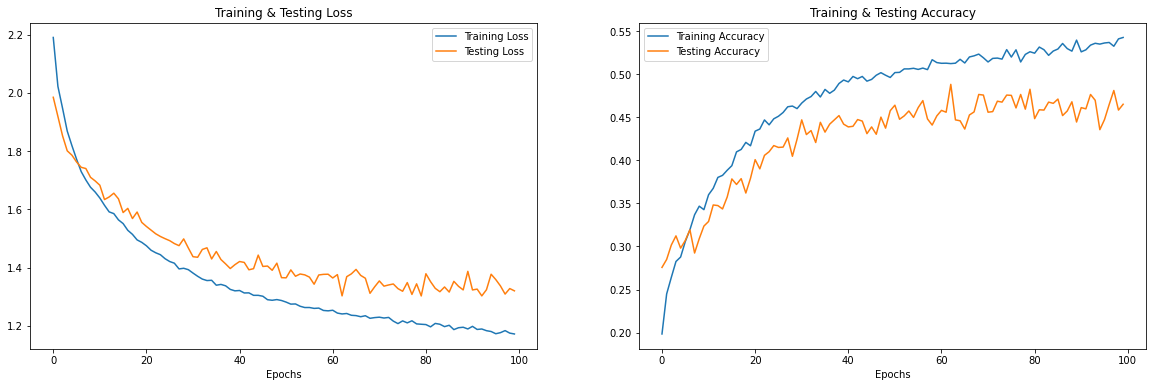

88/88 [==============================] - 21s 234ms/step - loss: 1.6474 - accuracy: 0.3901
Accuracy of our model on test data :  39.005327224731445 %


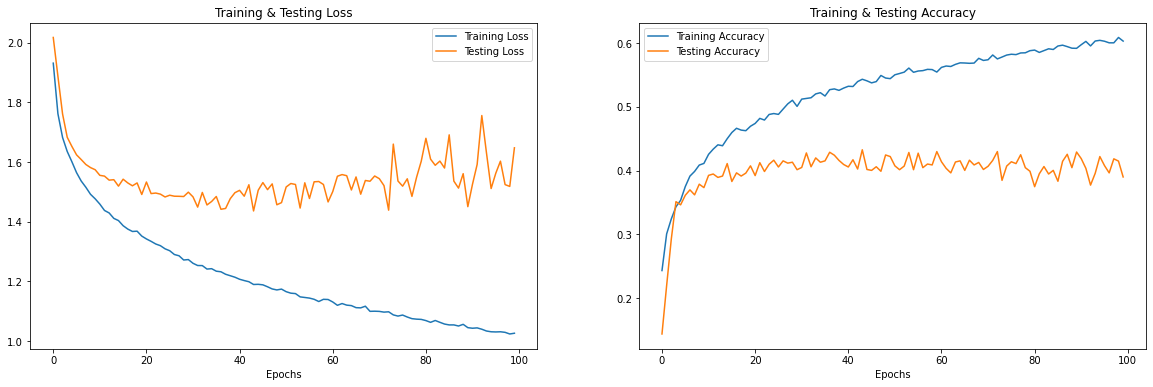

88/88 [==============================] - 21s 233ms/step - loss: 1.8288 - accuracy: 0.3567
Accuracy of our model on test data :  35.666075348854065 %


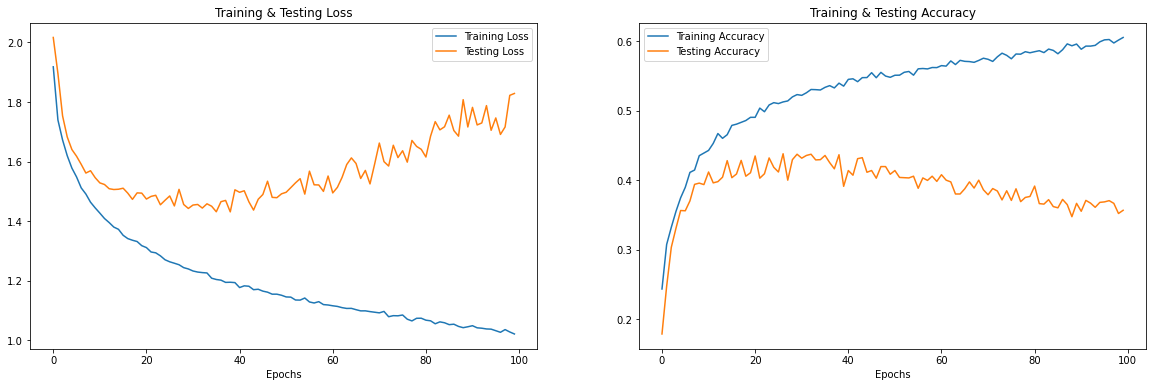

88/88 [==============================] - 21s 235ms/step - loss: 1.3568 - accuracy: 0.4636
Accuracy of our model on test data :  46.35879099369049 %


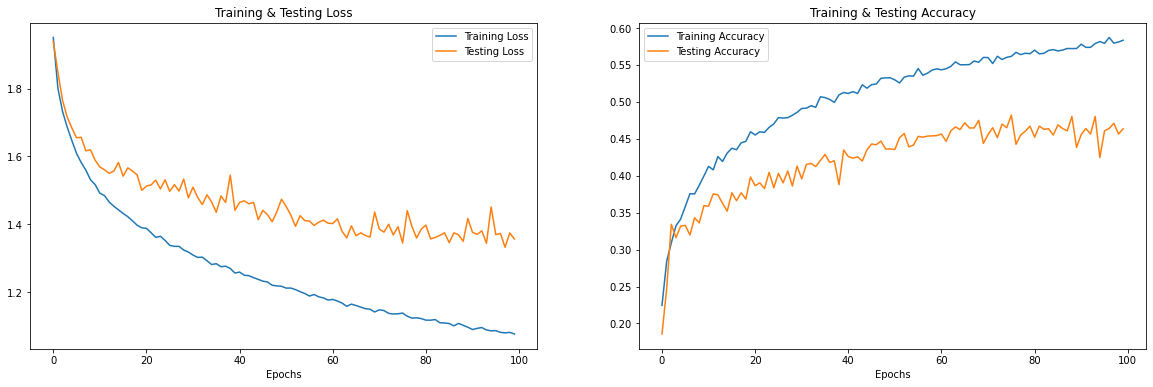

In [47]:
model_acuracy(cnn_model_noise, x_test_noise, y_test_noise, model_history_noise)
model_acuracy(cnn_model_shift, x_test_shift, y_test_shift, model_history_shift)
model_acuracy(cnn_model_pitch, x_test_pitch, y_test_pitch, model_history_pitch)
model_acuracy(cnn_model_speedNpitch, x_test_speedNpitch, y_test_speedNpitch, model_history_speedNpitch)

In [48]:
#Evaluate data.
def evaluate(model, x_test, y_test):

  score = model.evaluate(x_test, y_test, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

  return score

In [49]:
score_noise = evaluate(cnn_model_noise, x_test_noise, y_test_noise)
score_shift = evaluate(cnn_model_shift, x_test_shift, y_test_shift)
score_pitch = evaluate(cnn_model_pitch, x_test_pitch, y_test_pitch)
score_speedNpitch = evaluate(cnn_model_speedNpitch, x_test_speedNpitch, y_test_speedNpitch)


accuracy: 46.50%
accuracy: 39.01%
accuracy: 35.67%
accuracy: 46.36%


In [50]:
#Predicting on test data.
def predictions(model, x_test, y_test):
  
  pred = model.predict(x_test)
  pred = pred.argmax(axis=1)

  y_pred = pred.astype(int).flatten()
  y_pred = lb.inverse_transform(y_pred)
  y_pred = pd.DataFrame({'predictedvalues': y_pred})

  actual=y_test.argmax(axis=1)
  actual = actual.astype(int).flatten()
  actual = (lb.inverse_transform((actual)))
  actual = pd.DataFrame({'actualvalues': actual})

  y_check = np.argmax(y_test, axis=1)

  finaldf = actual.join(y_pred)
  finaldf[170:180]

  return y_check, y_pred, finaldf


In [51]:
y_pred_noise, y_check_noise, finaldf_noise = predictions(cnn_model_noise, x_test_noise, y_test_noise)
y_pred_shift, y_check_shift, finaldf_shift = predictions(cnn_model_shift, x_test_shift, y_test_shift)
y_pred_pitch, y_check_pitch, finaldf_pitch = predictions(cnn_model_pitch, x_test_pitch, y_test_pitch)
y_pred_speedNpitch, y_check_speedNpitch, finaldf_speedNpitch = predictions(cnn_model_speedNpitch, x_test_speedNpitch, y_test_speedNpitch)


In [52]:

def conf_matrix_graph(finaldf):
  
  plot_labels = ['angry', 'anxiety/fear', 'boredom', 'disgust', 'happiness', 'neutral', 'sadness']

  cnn_conf_matrix = pd.DataFrame(confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues,))

  fig, ax = plt.subplots()
  im = ax.imshow(cnn_conf_matrix, interpolation='nearest')
  ax.figure.colorbar(im, ax=ax)
  plt.title("Confusion Matrix")

  tick_marks = np.arange(len(plot_labels))
  plt.xticks(tick_marks, plot_labels, rotation=45)
  plt.yticks(tick_marks, plot_labels)


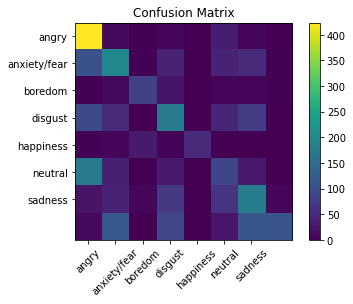

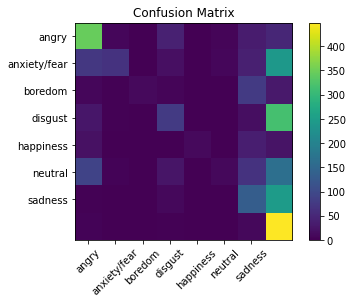

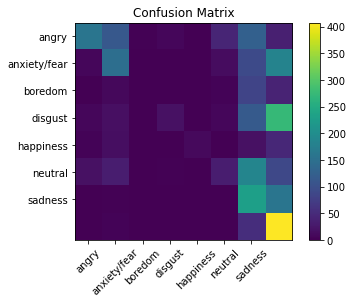

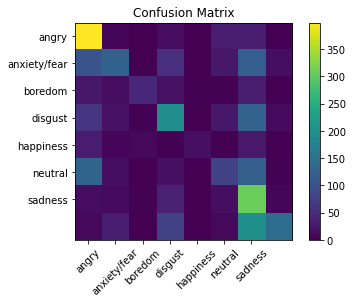

In [53]:
conf_matrix_graph(finaldf_noise)
conf_matrix_graph(finaldf_shift)
conf_matrix_graph(finaldf_pitch)
conf_matrix_graph(finaldf_speedNpitch)


In [54]:
#Classification report
def class_report(finaldf):
  classes = finaldf.actualvalues.unique()
  classes.sort()    
  
  print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))
  

In [55]:
class_report(finaldf_noise)
class_report(finaldf_shift)
class_report(finaldf_pitch)
class_report(finaldf_speedNpitch)

              precision    recall  f1-score   support

       angry       0.51      0.88      0.64       484
anxiety/fear       0.42      0.45      0.43       443
     boredom       0.67      0.61      0.64       137
     disgust       0.39      0.40      0.40       439
    hapiness       0.98      0.54      0.70        94
   happiness       0.29      0.24      0.26       360
     neutral       0.39      0.46      0.42       391
     sadness       0.89      0.24      0.38       467

    accuracy                           0.47      2815
   macro avg       0.57      0.48      0.48      2815
weighted avg       0.52      0.47      0.45      2815

              precision    recall  f1-score   support

       angry       0.60      0.71      0.65       484
anxiety/fear       0.76      0.15      0.25       443
     boredom       0.85      0.08      0.15       137
     disgust       0.42      0.17      0.24       439
    hapiness       1.00      0.12      0.21        94
   happiness       0.38 